# Wälzlagerfehlerdiagnose mittels Deep Learning

Wir wollen mit einem neuronalen Netzwerk folgende zwei Fehler identifizieren:
1. Außenringfehler und
2. Innenringfehler.

Welche Ansätze kennen Sie, um eine Fehlerdiagnose mithilfe von Künstlicher Intelligenz zu erreichen?

## 1. Daten laden und ansehen

Zuerst schauen wir uns die Daten an (Quelle: https://www.mfpt.org/fault-data-sets/).

Wir haben

1. Baseline - Wälzlagerdaten ohne Fehler
2. Outerracefault - Wälzlagerdaten mit Außenringfehler
3. Innerracefault - Wälzlagerdaten mit Innenringfehler

In der nächsten Zelle laden wir die Daten in das Notebook (Shift + Enter).

In [4]:
import pandas as pd
from scipy.io import loadmat
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import pywt
import math
from PIL import Image
from matplotlib import colormaps
import os

pd.set_option("display.max_rows", None)

# Load the MATLAB file
mat_data_baseline1 = loadmat('data/1 - Three Baseline Conditions/baseline_1.mat')
mat_data_baseline2 = loadmat('data/1 - Three Baseline Conditions/baseline_2.mat')
mat_data_baseline3 = loadmat('data/1 - Three Baseline Conditions/baseline_3.mat')
mat_data_outerracefault1 = loadmat('data/2 - Three Outer Race Fault Conditions/OuterRaceFault_1.mat')
mat_data_outerracefault2 = loadmat('data/2 - Three Outer Race Fault Conditions/OuterRaceFault_2.mat')
mat_data_outerracefault3 = loadmat('data/2 - Three Outer Race Fault Conditions/OuterRaceFault_3.mat')

mat_data_outerracefault_vload1 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_1.mat')
mat_data_outerracefault_vload2 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_2.mat')
mat_data_outerracefault_vload3 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_3.mat')
mat_data_outerracefault_vload4 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_4.mat')
mat_data_outerracefault_vload5 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_5.mat')
mat_data_outerracefault_vload6 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_6.mat')
mat_data_outerracefault_vload7 = loadmat('data/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_7.mat')

mat_data_innerracefault_vload1 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_1.mat')
mat_data_innerracefault_vload2 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_2.mat')
mat_data_innerracefault_vload3 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_3.mat')
mat_data_innerracefault_vload4 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_4.mat')
mat_data_innerracefault_vload5 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_5.mat')
mat_data_innerracefault_vload6 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_6.mat')
mat_data_innerracefault_vload7 = loadmat('data/4 - Seven Inner Race Fault Conditions/InnerRaceFault_vload_7.mat')

# Create DataFrames
baseline1 = pd.DataFrame(mat_data_baseline1['bearing']['gs'][0,0], columns=['Signal'])
baseline2 = pd.DataFrame(mat_data_baseline2['bearing']['gs'][0,0], columns=['Signal'])
baseline3 = pd.DataFrame(mat_data_baseline3['bearing']['gs'][0,0], columns=['Signal'])
outerracefault1 = pd.DataFrame(mat_data_outerracefault1['bearing']['gs'][0,0], columns=['Signal'])
outerracefault2 = pd.DataFrame(mat_data_outerracefault2['bearing']['gs'][0,0], columns=['Signal'])
outerracefault3 = pd.DataFrame(mat_data_outerracefault3['bearing']['gs'][0,0], columns=['Signal'])

outerracefault_vload1 = pd.DataFrame(mat_data_outerracefault_vload1['bearing']['gs'][0,0], columns=['Signal'])
outerracefault_vload2 = pd.DataFrame(mat_data_outerracefault_vload2['bearing']['gs'][0,0], columns=['Signal'])
outerracefault_vload3 = pd.DataFrame(mat_data_outerracefault_vload3['bearing']['gs'][0,0], columns=['Signal'])
outerracefault_vload4 = pd.DataFrame(mat_data_outerracefault_vload4['bearing']['gs'][0,0], columns=['Signal'])
outerracefault_vload5 = pd.DataFrame(mat_data_outerracefault_vload5['bearing']['gs'][0,0], columns=['Signal'])
outerracefault_vload6 = pd.DataFrame(mat_data_outerracefault_vload6['bearing']['gs'][0,0], columns=['Signal'])
outerracefault_vload7 = pd.DataFrame(mat_data_outerracefault_vload7['bearing']['gs'][0,0], columns=['Signal'])

innerracefault_vload1 = pd.DataFrame(mat_data_innerracefault_vload1['bearing']['gs'][0,0], columns=['Signal'])
innerracefault_vload2 = pd.DataFrame(mat_data_innerracefault_vload2['bearing']['gs'][0,0], columns=['Signal'])
innerracefault_vload3 = pd.DataFrame(mat_data_innerracefault_vload3['bearing']['gs'][0,0], columns=['Signal'])
innerracefault_vload4 = pd.DataFrame(mat_data_innerracefault_vload4['bearing']['gs'][0,0], columns=['Signal'])
innerracefault_vload5 = pd.DataFrame(mat_data_innerracefault_vload5['bearing']['gs'][0,0], columns=['Signal'])
innerracefault_vload6 = pd.DataFrame(mat_data_innerracefault_vload6['bearing']['gs'][0,0], columns=['Signal'])
innerracefault_vload7 = pd.DataFrame(mat_data_innerracefault_vload7['bearing']['gs'][0,0], columns=['Signal'])

### Nehmen Sie sich etwas Zeit und schauen Sie sich die Daten an.

Wählen Sie sich einen Datensatz (zum Beispiel **baseline1**, siehe oben) aus und nutzen Sie folgende Befehle:

- .size - Ziegt die Anzahl der Datenpunkte an
- .head() - Zeigt die ersten Daten an
- .tail() - Zeigt die letzten Daten an
- .iloc[from:to] - Zeigt die Daten für den Bereich from - to an.
- .min() | .max() | .mean() | .median() - Mathematische Standardoperationen
- (für weiterführende Befehle siehe: https://pandas.pydata.org/docs/reference/frame.html)

#### Frage
Welche Struktur haben die Daten? Welche Struktur würden Sie erwarten?
#### Aufgabe
Das Signal von **baseline1** wurde 6 Sekunden lang aufgenommen. <br>
Bestimmen Sie die Abtastrate des Signals in Hz.


In [48]:
# choose dataset and perform action
baseline1.iloc[0:10]

,Signal
0,0.831588
1,0.038702
2,0.467645
3,0.661645
4,1.770335
5,1.523985
6,1.916429
7,0.559249
8,0.327014
9,-1.082491


### Mit der folgenden Code-Zelle können Sie die Daten grafisch darstellen.

#### Frage
Können Sie anhand der Daten erkennen, dass ein Außenring- oder Innenringfehler vorliegt?
#### Aufgabe
Die sogenannte _ball pass frequency_ für den Außenring beträgt ungefähr 80 Hz. <br>
Das heißt, im Datensatz **outerracefault3** erwarten wir 80 mal pro Sekunde eine größere Amplitude im Vibrationssignal. <br>

Können Sie das in den Daten bestätigen?

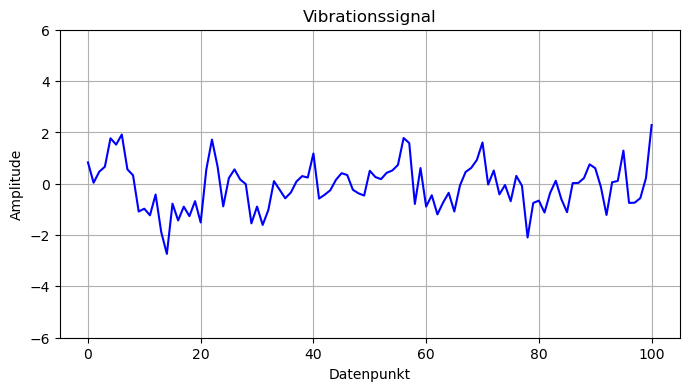

interactive(children=(IntRangeSlider(value=(0, 100), description='Range', layout=Layout(width='80%'), max=5859…

In [47]:
# Function to update the plot based on the range slider values
usedDataSet = baseline1   # change this to use another dataset.
min = 0                   # you can change this value (start of the visualization)
max = 100              # you can change this value (end of the visualization)

def update_plot(x_range):
    x_min, x_max = x_range
    min = x_min
    max = x_max
    
    # Plot the data within the selected range
    plt.figure(figsize=(8, 4))
    plt.plot(usedDataSet.Signal.loc[x_min:x_max], color='blue')
    plt.ylim(-6, 6)
    plt.xlabel('Datenpunkt')
    plt.ylabel('Amplitude')
    plt.title('Vibrationssignal')
    plt.grid(True)
    plt.show()

# Create a range slider widget for selecting the x range
range_slider = widgets.IntRangeSlider(
    value=[min, max],
    min=0,
    max=585936,
    step=100,
    description='Range',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

# Display the range slider and use it to update the plot interactively
widgets.interactive(update_plot, x_range=range_slider)

## Trainings- und Testdaten erzeugen
Um Trainings- und Testdaten zu erzeugen, zerlegen wir den Datensatz (die 6 Sekunden) in kleinere Zeiteinheiten (0,05 Sekunden). Wir erzeugen aus den Daten Bilder mit einer Größe von 227 x 227 Pixeln.

#### Frage
Warum müssen die Bilder eine einheitliche Größe haben?

#### Aufgabe
Probieren Sie andere Bildergrößen aus. Können Sie sich Alternativen vorstellen?

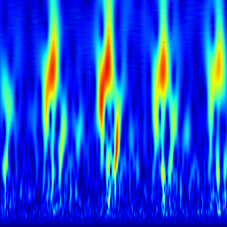

In [63]:
usedDataSet = outerracefault3   # change this to use another dataset.
image_width = 227 # CHANGE this value
image_height = 227 # CHANGE this value
interval = 5000 # CHANGE this value to use a different interval

"""==============================================="""

N = math.floor(len(usedDataSet) / interval)

# Define the wavelet and scales
wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
sampling_period = 0.000020
scales = np.arange(1,128)# TODO: this needs to be adjusted

# Perform CWT
coefficients, frequencies = pywt.cwt(usedDataSet['Signal'].loc[:interval], scales, wavelet)
cfs = abs(coefficients)
flipped_cfs = np.flip(cfs, axis=0)
rescaled_cfs = np.round(255 * (flipped_cfs - flipped_cfs.min()) / (flipped_cfs.max() - flipped_cfs.min())).astype(int)

colormap = colormaps['jet'].resampled(320)
img = colormap(rescaled_cfs / 255.0)[:, :, :3] # rm alpha component
img = (img * 255).astype(np.uint8)
image = Image.fromarray(img)

resized_image = image.resize((image_width,image_height), Image.Resampling.LANCZOS)
resized_image

### Das erzeugen aller Bilder braucht relativ viel Zeit. Deshalb haben wir das hier schon vorbereitet.

#### Aufgabe
Schauen Sie sich die Struktur und die Bilder in dem Ordner *images* an. <br>
Können Sie die Ordnerstruktur erklären?

#### Hinweis
Die folgende Code-Zelle erzeugt die Bilder. Das dauert (je nach Computerleistung) ca. 7 Minuten.
Wenn Sie das Beispiel Zuhause nachstellen wollen, führen Sie die Funktion createAllData() (siehe letzte Zeile) aus.

In [93]:
def createData(data, path, filename):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
    # Which interval to choose?
    interval = 5000
    N = math.floor(len(data) / interval)

    # Define the wavelet and scales
    wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
    sampling_period = 0.000020
    scales = np.arange(1,128)# TODO: this needs to be adjusted

    for i in range(N):
        # Perform CWT
        coefficients, frequencies = pywt.cwt(data['Signal'].loc[i*interval:(i+1)*interval], scales, wavelet)

        cfs = abs(coefficients)

        flipped_cfs = np.flip(cfs, axis=0)

        rescaled_cfs = np.round(255 * (flipped_cfs - flipped_cfs.min()) / (flipped_cfs.max() - flipped_cfs.min())).astype(int)

        colormap = colormaps['jet'].resampled(320)
        img = colormap(rescaled_cfs / 255.0)[:, :, :3] # rm alpha component
        img = (img * 255).astype(np.uint8)
        image = Image.fromarray(img)
        # Warum wird gerade 227x227 verwendet?
        resized_image = image.resize((227,227), Image.Resampling.LANCZOS)
        resized_image.save(f"{path}/{filename}-{i}.jpg", "JPEG")

def createAllData():
    createData(baseline1, "images/train/baseline", "baseline1")
    createData(baseline2, "images/train/baseline", "baseline2")

    createData(outerracefault1, "images/train/outerracefault", "outerracefault1")
    createData(outerracefault2, "images/train/outerracefault", "outerracefault2")
    createData(outerracefault_vload1, "images/train/outerracefault", "outerracefault_vload1")
    createData(outerracefault_vload2, "images/train/outerracefault", "outerracefault_vload2")
    createData(outerracefault_vload3, "images/train/outerracefault", "outerracefault_vload3")
    createData(outerracefault_vload4, "images/train/outerracefault", "outerracefault_vload4")
    createData(outerracefault_vload5, "images/train/outerracefault", "outerracefault_vload5")

    createData(innerracefault_vload1, "images/train/innerracefault", "innerracefault_vload1")
    createData(innerracefault_vload2, "images/train/innerracefault", "innerracefault_vload2")
    createData(innerracefault_vload3, "images/train/innerracefault", "innerracefault_vload3")
    createData(innerracefault_vload4, "images/train/innerracefault", "innerracefault_vload4")
    createData(innerracefault_vload5, "images/train/innerracefault", "innerracefault_vload5")

    # create test_data
    createData(baseline3, "images/test/baseline", "baseline3")
    createData(outerracefault3, "images/test/outerracefault", "outerracefault3")

    createData(outerracefault_vload6, "images/test/outerracefault", "outerracefault_vload6")
    createData(outerracefault_vload7, "images/test/outerracefault", "outerracefault_vload7")

    createData(innerracefault_vload6, "images/test/innerracefault", "innerracefault_vload6")
    createData(innerracefault_vload7, "images/test/innerracefault", "innerracefault_vload7")

# createAllData()    # uncomment this line to create all the data

## Neuronales Netz trainieren

Wir nehmen ein vortrainiertes Modell mit dem Namen _SqueezeNet_ (https://en.wikipedia.org/wiki/SqueezeNet).

#### Frage
Welchen Vorteil hat es, ein bereits (vor-)trainiertes Modell zu benutzen?

In [65]:
num_classes = 3 

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
import torch.optim as optim

# Load the pre-trained SqueezeNet model
squeezenet = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)

squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = num_classes

Im nächsten Schritt laden wir die Trainings- und Testdaten.

In [68]:
shuffleTrainingData = True  # You can change this value
shuffleTestData = True  # You can change this value
batchSize = 32 # You can change this value

folderForTraining = 'images/train'
folderForTesting = 'images/test' 

"""==============================================="""

# Define transformations for the training and validation datasets
transform = transforms.Compose([
   # transforms.Resize((224, 224)),  # Resizes the image to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the image based on ImageNet statistics
])

# Load your dataset
train_dataset = datasets.ImageFolder(root=folderForTraining, transform=transform)
val_dataset = datasets.ImageFolder(root=folderForTesting, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=shuffleTrainingData)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize, shuffle=shuffleTestData)

Jetzt können wir das Training starten.

Zunächst müssen Sie festlegen, wie viele Durchläufe (= Epochen) Sie haben wollen.
Legen Sie anschließend die Lernrate fest.

ACHTUNG: Je mehr Epochen Sie wählen und je kleiner die Lernrate ist, umso länger braucht das Training. Starten Sie diesen Code, wenn Sie alles eingestellt haben.
(8 Epochen, 0.001 = ~6 Minuten)

In [67]:
num_epochs = 8 # CHANGE this value
learnRate = 0.0001 # CHANGE this value

"""==============================================="""

# Specify the loss function and optimizer
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters(), lr=learnRate)


# Assuming losses and accuracies are collected during training
train_losses = []  # fill these with your training loss values
val_accuracies = []  # fill these with your validation accuracy values
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
squeezenet.to(device)

for epoch in range(num_epochs):
    squeezenet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = squeezenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    train_losses.append(running_loss/len(train_loader))

    # Validation
    squeezenet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = squeezenet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')
    val_accuracies.append(100 * correct / total)

Epoch [1/8], Loss: 0.4472
Validation Accuracy: 92.88%
Epoch [2/8], Loss: 0.0179
Validation Accuracy: 95.16%
Epoch [3/8], Loss: 0.0012
Validation Accuracy: 96.01%
Epoch [4/8], Loss: 0.0003
Validation Accuracy: 97.15%
Epoch [5/8], Loss: 0.0002
Validation Accuracy: 97.44%
Epoch [6/8], Loss: 0.0001
Validation Accuracy: 96.30%
Epoch [7/8], Loss: 0.0001
Validation Accuracy: 96.87%
Epoch [8/8], Loss: 0.0001
Validation Accuracy: 96.87%


## Ergebnisse visualisieren

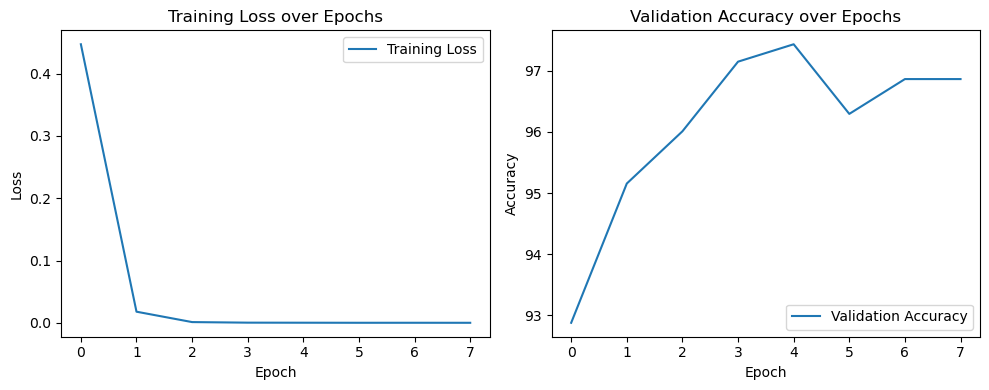

In [69]:
import matplotlib.pyplot as plt

# Plot loss over epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

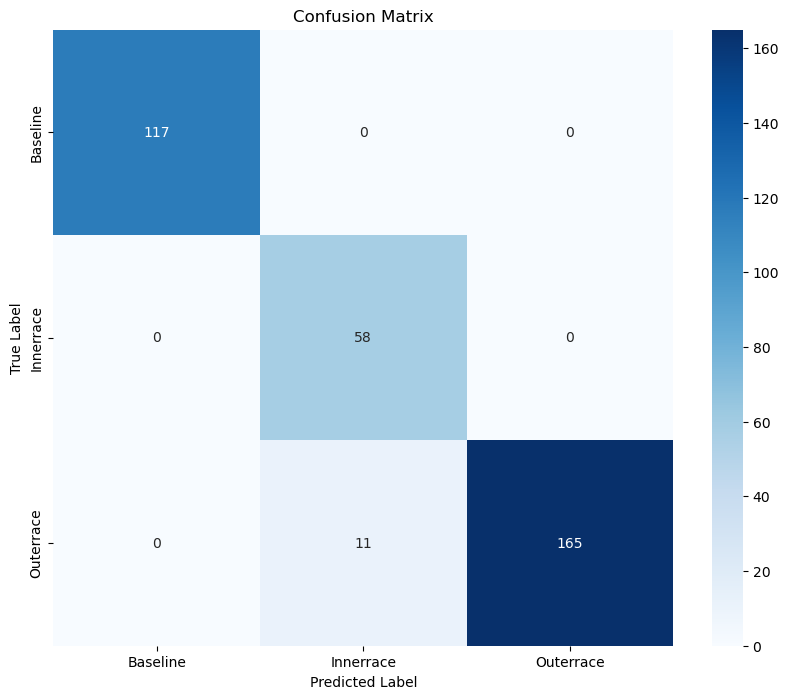

In [71]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Gather all predictions and true labels
all_preds = torch.tensor([])
all_labels = torch.tensor([])

# Make predictions on entire validation set
squeezenet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = squeezenet(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

# Compute confusion matrix
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

df_cm = pd.DataFrame(cm, index=["Baseline","Innerrace","Outerrace"], columns=["Baseline","Innerrace","Outerrace"])

#category_mapping = { 'Baseline': 0, 'Innerrace': 1, 'Outerrace': 2 }

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the 

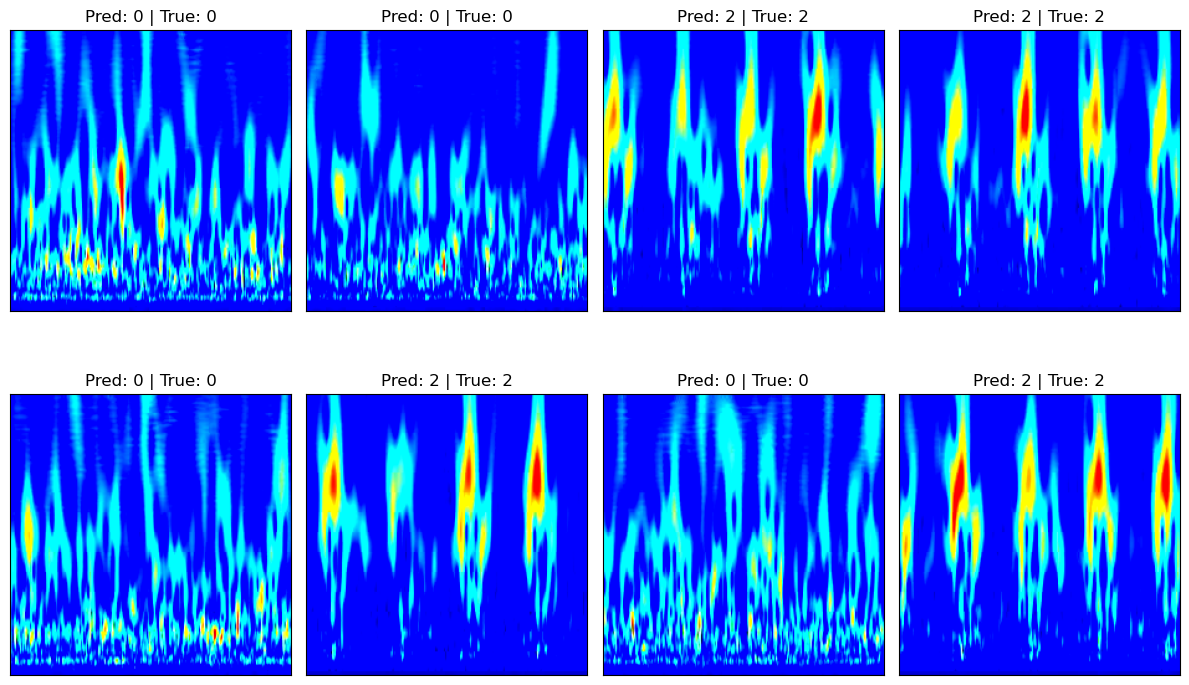

In [94]:
# Select a batch of images from your validation set
import numpy as np
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Pass through model
outputs = squeezenet(images.to(device))
_, preds = torch.max(outputs, 1)

# Move data to CPU for numpy processing
images, preds, labels = images.cpu(), preds.cpu(), labels.cpu()

# Display images with predictions
fig = plt.figure(figsize=(12, 8))
for idx in np.arange(8):  # visualize first 8 predictions
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5  # unnormalize if needed
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # convert from Tensor image
    ax.set_title(f"Pred: {preds[idx]} | True: {labels[idx]}")
plt.tight_layout()
plt.show()